# Preambles

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as evol_gates
import plotting_settings
import scipy.linalg
from scipy.optimize import minimize

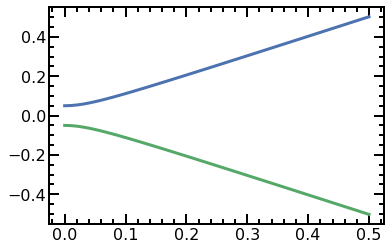

In [2]:
#Define coupled two-level system Hamiltonian
IZ = tensor(qeye(2), sigmaz())
ZI = tensor(sigmaz(), qeye(2))
XI = tensor(sigmax(), qeye(2))
IX = tensor(qeye(2), sigmax())
YI = tensor(sigmay(), qeye(2))
IY = tensor(qeye(2), sigmay())
XX = tensor(sigmax(), sigmax())

def two_q_hamiltonian(w1, w2, J):
    return -0.5*w1*ZI - 0.5*w2*IZ + J*XX

#TESTING
w1 = 0.4
w2 = 0.5
g = np.linspace(0,0.5,51)
energies = np.zeros((len(g), 4))

for idx, J in enumerate(g):
    eig_energies, eig_states = two_q_hamiltonian(w1, w2, J).eigenstates()
    energies[idx,:] = eig_energies
    
plt.plot(g, energies[:,2])  
plt.plot(g, energies[:,1]) 

# Get the correct coupling constant

Text(0, 0.5, '$|\\delta f _{|10\\rangle - |01\\rangle}|~(\\mathrm{MHz})$')

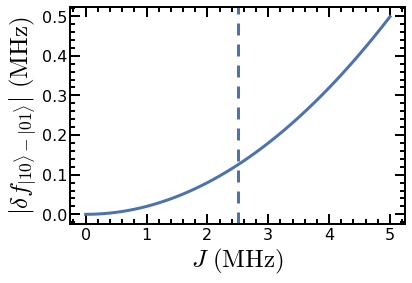

In [3]:
g = np.linspace(0,0.005,51)
energies = np.zeros((len(g), 4))

for idx, J in enumerate(g):
    eig_energies, eig_states = two_q_hamiltonian(w1, w2, J).eigenstates()
    energies[idx,:] = eig_energies
freq_shift = energies[:,2]-energies[:,1]    
freq_anchor = freq_shift[0]  
freq_shift = freq_shift - freq_anchor
plt.plot(g*1e3, freq_shift*1e3)
plt.axvline(x = 2.5, linestyle = '--')
plt.xlabel (r'$J~(\mathrm{MHz})$')
plt.ylabel (r'$|\delta f _{|10\rangle - |01\rangle}|~(\mathrm{MHz})$')

# Apply a microwave drive

## Parameters

In [14]:
#Static part
#Ravi's paper LO is at 5.425 GHz, detuned by -130MHz, qubit 4 is at 5.25 GHz, qubit 4 is at 5.3
#zeta_ZZ -> 4 MHz, driven with same aplitubes

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

#Driving part
delta_omega_d = 40e-3
# delta_omega_d = 02
# delta_omega_d = eig_energies[2]-eig_energies[0] - (eig_energies[1]-eig_energies[0])
# delta_omega_d = 1*delta_omega_d/2
coupl = 30
coupl_const = coupl*1e-3*2*np.pi
# 1 means 2pi phase in 500ns - Omega = 2 MHz 
drive_freq = eig_energies[1]-eig_energies[0] + delta_omega_d #qubit A
# print (drive_freq)
H1 = coupl_const*(XI+IX) #Driving both qubits at this frequency\

#Gate parameters
T_start = 0
T_gate = 300
shape = 'cosflattop'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2))
U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

## Population

Text(0, 0.5, '$P$')

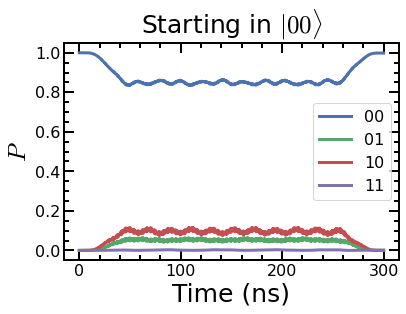

In [15]:
state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_10)/np.sqrt(2)
sup_state1 = (state_01 + state_11)/np.sqrt(2)

trans_prob_00_00 = expect(state_00 * state_00.dag(),U_t*state_00)
trans_prob_00_01 = expect(state_01 * state_01.dag(),U_t*state_00)
trans_prob_00_10 = expect(state_10 * state_10.dag(),U_t*state_00)
trans_prob_00_11 = expect(state_11 * state_11.dag(),U_t*state_00)

sx0 = expect(XI,U_t*sup_state0)
sy0 = expect(YI,U_t*sup_state0)
sz0 = expect(ZI,U_t*sup_state0)

sx1 = expect(XI,U_t*sup_state1)
sy1 = expect(YI,U_t*sup_state1)
sz1 = expect(ZI,U_t*sup_state1)
R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)

plt.plot(t_points, trans_prob_00_00, label = '00')
plt.plot(t_points, trans_prob_00_01, label = '01')
plt.plot(t_points, trans_prob_00_10, label = '10')
plt.plot(t_points, trans_prob_00_11, label = '11')
# plt.plot(t_points, np.cos(2*np.pi*coupl_const*1e-2 * 1e9 *t_points*1e-9))
plt.legend()
plt.title(r'Starting in $|00\rangle$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

# b = Bloch()
# b.add_points([sx0, sy0, sz0], meth='l')
# b.make_sphere()

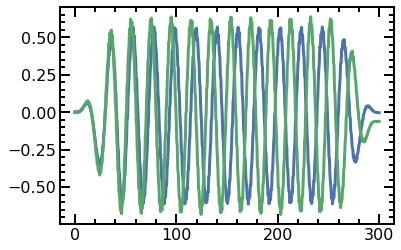

In [16]:
plt.plot(t_points, sz0)
plt.plot(t_points, sz1)

## Entanglement metric

0.9982333158632993


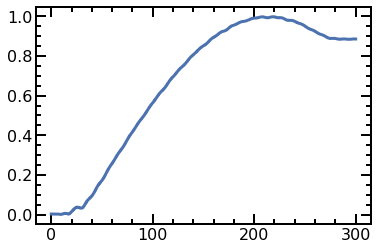

In [17]:
plt.plot(t_points, R, label = 'R')
optimal_t = np.argmax(R)
print (np.max(R))

## Optimization

In [20]:
# def infidelity(x):
#     coupl_const = x[0]
#     H1 = coupl_const*(XI+IX)
#     U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
#         T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
#     sx0 = expect(XI,U_t*sup_state0)
#     sy0 = expect(YI,U_t*sup_state0)
#     sz0 = expect(ZI,U_t*sup_state0)

#     sx1 = expect(XI,U_t*sup_state1)
#     sy1 = expect(YI,U_t*sup_state1)
#     sz1 = expect(ZI,U_t*sup_state1)
#     R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
#     return (1.0 - R[-1])

def infidelity(x):
    coupl = x[0]
    drive_freq = x[1]
    H1 = coupl_const*(XI+IX)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)
    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]
#     u00 = U.matrix_element(state_00, state_00)
#     u01 = U.matrix_element(state_01, state_01)
#     u10 = U.matrix_element(state_10, state_10)
#     u11 = U.matrix_element(state_11, state_11)
#     rot_angle = abs(np.angle(u11) - np.angle(u10))
    U_ideal = cphase(np.pi)
    U_real = U
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    
    return abs(1-fidel)

drive_freq_guess = drive_freq = eig_energies[1]-eig_energies[0] + delta_omega_d
x0 = [50,drive_freq_guess]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-8)
print (xopt.x)
print(1-infidelity(xopt.x))

Exception: Urecognized pulse shape.

In [153]:
coupl_const = xopt.x[0]
H1 = coupl_const*(XI+IX)
U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
    T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
sx0 = expect(XI,U_t*sup_state0)
sy0 = expect(YI,U_t*sup_state0)
sz0 = expect(ZI,U_t*sup_state0)

sx1 = expect(XI,U_t*sup_state1)
sy1 = expect(YI,U_t*sup_state1)
sz1 = expect(ZI,U_t*sup_state1)
R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)

optimal_t = -1

In [154]:
# Z corrections

u00 = U_t[optimal_t].matrix_element(state_00, state_00)
u01 = U_t[optimal_t].matrix_element(state_01, state_01)
u10 = U_t[optimal_t].matrix_element(state_10, state_10)
u11 = U_t[optimal_t].matrix_element(state_11, state_11)
# phase1 = np.angle(u00*u01/(u10*u11)) #include zz
# phase2 = np.angle(u00*u10/(u01*u11))
phase1 = np.angle(u01/u00)
phase2 = np.angle(u10/u00)
# print(phase1)
# print(phase2)

single_qu_z = 0
single_qu_z = single_qu_z + state_00*state_00.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()

# single_qu_z = 0
# single_qu_z = single_qu_z + np.exp(-1j*phase2)*np.exp(-1j*phase1)*state_00*state_00.dag()
# single_qu_z = single_qu_z + state_01*state_01.dag()
# single_qu_z = single_qu_z + state_10*state_10.dag()
# single_qu_z = single_qu_z + np.exp(1j*(phase1 + phase2))*state_11*state_11.dag()

U = single_qu_z*U_t[optimal_t]

# X, Y corrections
# u_00_01 = U_t[optimal_t].matrix_element(state_00, state_01)
# u_00_10 = U_t[optimal_t].matrix_element(state_00, state_10)
# print (abs(u_00_01))
# print (abs(u_00_10))

# Check it!
u00 = U.matrix_element(state_00, state_00)
u01 = U.matrix_element(state_01, state_01)
u10 = U.matrix_element(state_10, state_10)
u11 = U.matrix_element(state_11, state_11)
# phase1 = np.angle(u01/u00)
# phase2 = np.angle(u10/u00)
print (np.angle(u00))
print (np.angle(u01))
print (np.angle(u10))
print (np.angle(u11))

# print (U.matrix_element(state_00, state_00).dag())

print (abs(u00))
print (abs(u01))
print (abs(u10))
print (abs(u11))

# print (U)
# print(phase1)
# print(phase2)

-0.368136891775341
-0.3681368917753411
-0.3681368917753411
2.7279271255113144
0.9978579725315787
0.9998949199028753
0.9982587832515764
0.9995947154777376


In [155]:
# print (cphase(np.pi))
u_test = np.diag([u00,u10,u01,u11])
u_test = Qobj(u_test)
u_test.dims = [[2,2],[2,2]]

## Tomography

<ipython-input-156-8376bb12c977>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
<ipython-input-156-8376bb12c977>:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_ideal_2q = np.linalg.lstsq(p_in, p_out)[0]


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffe0bdada90>)

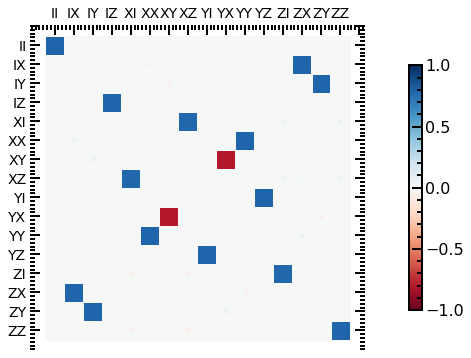

In [156]:
prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_generator:
    for q2gate in prep_generator:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)

meas_generator = [qeye(2), sigmax(), sigmay(), sigmaz()]
meas_rotations = []
for q1gate in meas_generator:
    for q2gate in meas_generator:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
        
p_in = np.zeros((16,16)) 
p_out = np.zeros((16,16)) 

gnd_state = tensor(basis(2,0), basis(2,0))

#Define gate here
# gate_op = tensor(qeye(2), rx(np.pi/2))
# gate_op = tensor(rx(np.pi/2), qeye(2))
# gate_op = cnot()
# gate_op = cphase(np.pi)
# gate_op = rzx_m
# U_Z2I = tensor(rz(np.pi/2), qeye(2))
# U_IX2 = tensor(qeye(2), rx(np.pi/2))
# gate_op = U_Z2I * U * U_IX2
gate_op = U

#PTM here
for i, rot_i in enumerate(prep_rotations):
    for j, rot_j in enumerate(meas_rotations):
        p_in[i,j] = expect(rot_j, rot_i*gnd_state)
        p_out[i,j] = expect(rot_j, gate_op*(rot_i*gnd_state))        
ptm_ideal_2q = np.linalg.lstsq(p_in, p_out)[0]

str_primitive = ["I","X","Y","Z"]
op_label = []
for prim1 in str_primitive:
    for prim2 in str_primitive:
        op_label.append(prim1+prim2)
# print (op_label)
qutip.hinton(ptm_ideal_2q, xlabels = op_label, ylabels = op_label)

In [159]:
print (xopt.x[2])

57.219583130183885


In [158]:
U_ideal = cphase(np.pi)
U_real = gate_op

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
print (fidel)

0.9977245069256233


<ipython-input-158-7d83cc7ac2cb>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = cphase(np.pi)


## Phase

Text(0, 0.5, 'Radian')

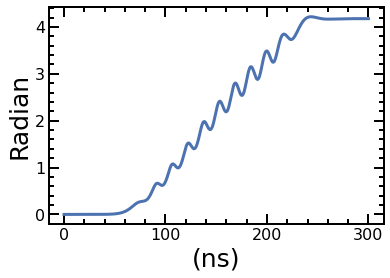

In [87]:
phase = np.zeros_like(t_points)
for tind in range(len(t_points)):
    u00 = U_t[tind].matrix_element(state_00.dag(), state_00)
    u01 = U_t[tind].matrix_element(state_01.dag(), state_01)
    u10 = U_t[tind].matrix_element(state_10.dag(), state_10)
    u11 = U_t[tind].matrix_element(state_11.dag(), state_11)
    phase[tind] = np.angle(u11 * u00 / (u10 * u01))
plt.plot(t_points, np.unwrap(phase))
plt.xlabel('(ns)')
plt.ylabel('Radian')

In [88]:
#Extract the phase rate
def linear_func(x,slope,offsetx, offsety):
    return slope*(x-offsetx)+offsety
from scipy.optimize import curve_fit
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase), xdata = t_points)
print (opt[0]*1e3/(2*np.pi) , "MHz") 

2.9550547701870418 MHz


# Sweeping gate parameters
## Sweep qubit detuning

In [121]:
freq_delta_array = np.linspace(40,340,31)*1e-3
infidelity_array = np.zeros_like(freq_delta_array)
amplitude_array = np.zeros_like(freq_delta_array)

for idx, freq_delta in enumerate(freq_delta_array):
    w2 = w1 + freq_delta
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates()
    delta_omega_d = freq_delta/2.0 - freq_delta*0.1
    drive_freq_guess = eig_energies[1]-eig_energies[0] + delta_omega_d #qubit A
    coupl_const_guess = freq_delta_array*1e3/20
    
    def infidelity(x):
        coupl_const = x[0]
        drive_freq = x[1]
        H1 = coupl_const*(XI+IX)
        U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
        u00 = U_t[-1].matrix_element(state_00, state_00)
        u01 = U_t[-1].matrix_element(state_01, state_01)
        u10 = U_t[-1].matrix_element(state_10, state_10)
        u11 = U_t[-1].matrix_element(state_11, state_11)
        phase1 = np.angle(u01/u00)
        phase2 = np.angle(u10/u00)
        single_qu_z = 0
        single_qu_z = single_qu_z + state_00*state_00.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
        single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
        U = single_qu_z*U_t[-1]
        U_ideal = cphase(np.pi)
        U_real = U
        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
        return abs(1-fidel)
    
    x0 = [coupl_const_guess, drive_freq_guess]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-8)
    amplitude_array[idx] = xopt.x[0]
    infidelity_array[idx] = infidelity(xopt.x)

<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = cphase(np.pi)
<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = cphase(np.pi)
<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = cphase(np.pi)
<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning

<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = cphase(np.pi)
<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = cphase(np.pi)
<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = cphase(np.pi)
<ipython-input-121-3eae201a3e7f>:31: DeprecationWarning

Text(0, 0.5, '$\\epsilon$')

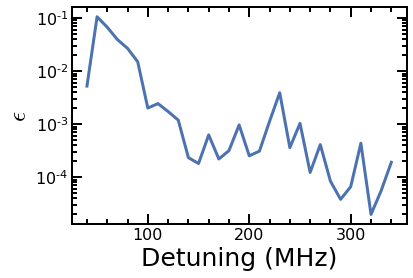

In [123]:
plt.semilogy(freq_delta_array*1e3, infidelity_array)
plt.xlabel('Detuning (MHz)')
plt.ylabel(r'$\epsilon$')

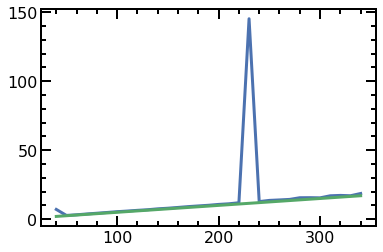

In [165]:
plt.plot(freq_delta_array*1e3, amplitude_array)
plt.plot(freq_delta_array*1e3, freq_delta_array*1e3/20)

# Three-qubitches
## Definitions

In [291]:
#Define coupled two-level system Hamiltonian
III = tensor(qeye(2), qeye(2), qeye(2))
IIZ = tensor(qeye(2), qeye(2), sigmaz())
IZI = tensor(qeye(2), sigmaz(), qeye(2))
ZII = tensor(sigmaz(), qeye(2), qeye(2))

IIX = tensor(qeye(2), qeye(2), sigmax())
IXI = tensor(qeye(2), sigmax(), qeye(2))
XII = tensor(sigmax(), qeye(2), qeye(2))

IIY = tensor(qeye(2), qeye(2), sigmay())
IYI = tensor(qeye(2), sigmay(), qeye(2))
YII = tensor(sigmay(), qeye(2), qeye(2))

XXI = tensor(sigmax(), sigmax(), qeye(2))
IXX = tensor(qeye(2), sigmax(), sigmax())

def three_q_hamiltonian(w1, w2, w3, J12, J23):
    return 0.5*w1*ZII + 0.5*w2*IZI + 0.5*w3*IIZ + J12*XXI + J23*IXX #+ 15*III

def r_metric(vec0, vec1):
    return 0.5*abs(vec0 - vec1)


#TESTING
w1 = 5.23
w2 = 5.29
w3 = 5.46
J12 = 2.5e-3
J23 = 2.73e-3
H0 = three_q_hamiltonian(w1, w2, w3, J12, J23)
eig_energies, eig_states = H0.eigenstates() #System
print (eig_energies)
print(eig_energies[1]-eig_energies[0])
print(eig_energies[2]-eig_energies[0])
print(eig_energies[3]-eig_energies[0])

[-7.99000129 -2.76010474 -2.69993979 -2.52995676  2.52995676  2.69993979
  2.76010474  7.99000129]
5.229896552267098
5.290061493022358
5.460044529509515


Text(0.5, 0, 'Frequency (GHz)')

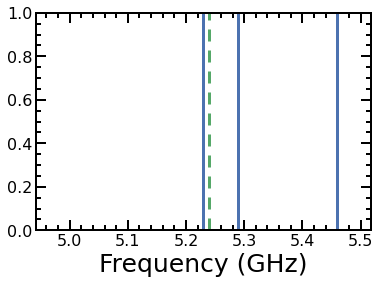

In [293]:
plt.axvline(x = w1)
plt.axvline(x = w2)
plt.axvline(x = w3)
plt.axvline(x = w1 + 10e-3, linestyle = '--', color = 'C1')
plt.xlabel('Frequency (GHz)')

## Parameters

In [344]:
#Driving part

#1-2
delta_omega_d = 0.02

drive_freq = eig_energies[1] - eig_energies[0] - delta_omega_d #qubit B
detune_1 = delta_omega_d
# detune_2 = delta_omega_d
# detune_3 = drive_freq - w3
ratio_amp12 = -2*J12/detune_1
# ratio_amp12 = 

coupl_const_A = 2
coupl_const_B = ratio_amp12*coupl_const_A
coupl_const_C = 0

H1 = coupl_const_A*XII + coupl_const_B*IXI + coupl_const_C*IIX

#Gate parameters
T_start = 0
T_gate = 400
shape = 'gaussflattop'
# shape = 'square'
sigma = 0.25
T_rise = 100
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2), qeye(2))
U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
U_nothing = gates.evolution_operator_microwave(-H0,H_dum, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

Text(0, 0.5, '$P$')

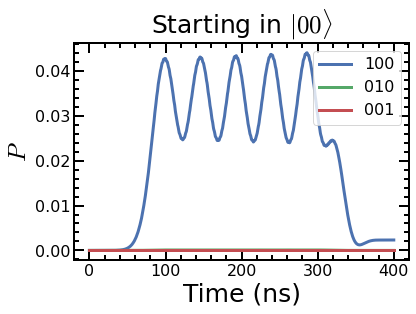

In [345]:
state_000 = eig_states[0]
state_100 = eig_states[1]
state_010 = eig_states[2]
state_001 = eig_states[3]
state_110 = eig_states[4]
state_101 = eig_states[5]
state_011 = eig_states[6]
state_111 = eig_states[7]


# sup_state0 = (state_00 + state_10)/np.sqrt(2)
# sup_state1 = (state_00 + state_01)/np.sqrt(2)

trans_prob_000_000 = expect(state_000 * state_000.dag(),U_t*state_000)
trans_prob_000_100 = expect(state_100 * state_100.dag(),U_t*state_000)
trans_prob_000_010 = expect(state_010 * state_010.dag(),U_t*state_000)
trans_prob_000_001 = expect(state_001 * state_001.dag(),U_t*state_000)

# sx0 = expect(XI,U_nothing*U_t*sup_state0)
# sy0 = expect(YI,U_nothing*U_t*sup_state0)
# sz0 = expect(ZI,U_nothing*U_t*sup_state0)
# sx1 = expect(IX,U_nothing*U_t*state_00)
# sy1 = expect(IY,U_nothing*U_t*state_00)
# sz1 = expect(IZ,U_nothing*U_t*state_00)

plt.plot(t_points, trans_prob_000_100, label = '100')
plt.plot(t_points, trans_prob_000_010, label = '010')
plt.plot(t_points, trans_prob_000_001, label = '001')

plt.legend()
plt.title(r'Starting in $|00\rangle$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

# b = Bloch()
# b.add_points([sx0, sy0, sz0], meth='l')
# b.make_sphere()

## Phase extraction for ZZ

$\zeta_{ZZI}$ 0.06887005851247682 MHz
$\zeta_{IZZ}$ 7.103845712620312e-06 MHz
$\zeta_{IZI}$ -0.074530357186536 MHz


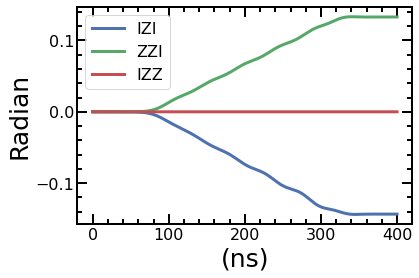

In [346]:
phase_12 = np.zeros_like(t_points)
phase_23 = np.zeros_like(t_points)
phase_2 = np.zeros_like(t_points)
U_rw = U_nothing*U_t
for tind in range(len(t_points)):
    u000 = U_rw[tind].matrix_element(state_000.dag(), state_000)
    u100 = U_rw[tind].matrix_element(state_100.dag(), state_100)
    u010 = U_rw[tind].matrix_element(state_010.dag(), state_010)
    u001 = U_rw[tind].matrix_element(state_001.dag(), state_001)
    u110 = U_rw[tind].matrix_element(state_110.dag(), state_110)
    u101 = U_rw[tind].matrix_element(state_101.dag(), state_101)
    u011 = U_rw[tind].matrix_element(state_011.dag(), state_011)
    u111 = U_rw[tind].matrix_element(state_111.dag(), state_111)
    phase_2[tind] = np.angle(u010 * u110 * u011 * u111/(u000 * u100 * u001 * u101))
    phase_12[tind] = np.angle(u110 * u000 * u111 * u001 / (u100 * u010 * u101 * u011))
    phase_23[tind] = np.angle(u011 * u000 * u111 * u100 / (u010 * u001 * u110 * u101))
    
plt.plot(t_points, np.unwrap(phase_2), label = 'IZI')
plt.plot(t_points, np.unwrap(phase_12), label = 'ZZI')
plt.plot(t_points, np.unwrap(phase_23), label = 'IZZ')
# plt.plot(t_points, np.unwrap(phase_123))
plt.xlabel('(ns)')
plt.ylabel('Radian')

opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_12), xdata = t_points)
print (r'$\zeta_{ZZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_23), xdata = t_points)
print (r'$\zeta_{IZZ}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_2), xdata = t_points)
print (r'$\zeta_{IZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 
plt.legend()

## Applying two drives

In [375]:
from Fluxonium_hamiltonians import qchard_evolgates_twod as gates_twod
#Static part
#Ravi's paper LO is at 5.425 GHz, detuned by -130MHz, qubit 4 is at 5.25 GHz, qubit 4 is at 5.3
#zeta_ZZ -> 4 MHz, driven with same aplitubes

delta_omega_d = 20e-3
coupl_const_A = 50
coupl_const_B = ratio_amp12*coupl_const_A*0.6
coupl_const_C = 100

drive_freq1 = eig_energies[1]-eig_energies[0] - delta_omega_d #qubit B
drive_freq2 = eig_energies[3]-eig_energies[0] + delta_omega_d
# print (drive_freq)
H1 = coupl_const_A*XII + 0.5*coupl_const_B*IXI + 0*IIX
H2 = 0*XII + coupl_const_B*IXI + coupl_const_C*IIX

#Gate parameters
T_start = 0
T_gate = 400
shape = 'gaussflattop'
sigma = 0.25
T_rise = 100
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2), qeye(2))
U_t = gates_twod.evolution_operator_microwave(H0,H1,H2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d1=drive_freq1, omega_d2 = drive_freq2)

U_nothing = gates.evolution_operator_microwave(-H0,H_dum, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq2)

$\zeta_{ZZI}$ 1.5064813717239152 MHz
$\zeta_{IZZ}$ 1.2843485817746236 MHz
$\zeta_{IZI}$ 2.7805680752262725 MHz


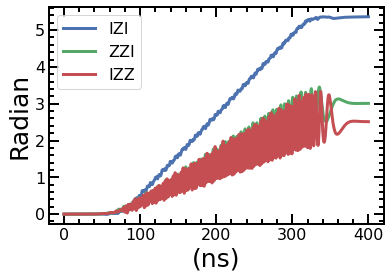

In [376]:
phase_12 = np.zeros_like(t_points)
phase_23 = np.zeros_like(t_points)
phase_123 = np.zeros_like(t_points)
U_rw = U_nothing*U_t
for tind in range(len(t_points)):
    u000 = U_rw[tind].matrix_element(state_000.dag(), state_000)
    u100 = U_rw[tind].matrix_element(state_100.dag(), state_100)
    u010 = U_rw[tind].matrix_element(state_010.dag(), state_010)
    u001 = U_rw[tind].matrix_element(state_001.dag(), state_001)
    u110 = U_rw[tind].matrix_element(state_110.dag(), state_110)
    u101 = U_rw[tind].matrix_element(state_101.dag(), state_101)
    u011 = U_rw[tind].matrix_element(state_011.dag(), state_011)
    u111 = U_rw[tind].matrix_element(state_111.dag(), state_111)
    phase_2[tind] = np.angle(u010 * u110 * u011 * u111/(u000 * u100 * u001 * u101))
    phase_12[tind] = np.angle(u110 * u000 * u111 * u001 / (u100 * u010 * u101 * u011))
    phase_23[tind] = np.angle(u011 * u000 * u111 * u100 / (u010 * u001 * u110 * u101))
    
plt.plot(t_points, np.unwrap(phase_2), label = 'IZI')
plt.plot(t_points, np.unwrap(phase_12), label = 'ZZI')
plt.plot(t_points, np.unwrap(phase_23), label = 'IZZ')
# plt.plot(t_points, np.unwrap(phase_123))
plt.legend()
plt.xlabel('(ns)')
plt.ylabel('Radian')

opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_12), xdata = t_points)
print (r'$\zeta_{ZZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_23), xdata = t_points)
print (r'$\zeta_{IZZ}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_2), xdata = t_points)
print (r'$\zeta_{IZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 

[-7.99000129 -2.76010474 -2.69993979 -2.52995676  2.52995676  2.69993979
  2.76010474  7.99000129]
-0.9990002809770118
0.9990004512906746
0.999000451290675
-0.9990002809770117


Text(0, 0.5, '$P$')

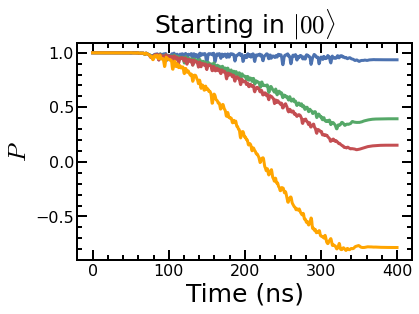

In [377]:
state_000 = eig_states[0]
state_100 = eig_states[1]
state_010 = eig_states[2]
state_001 = eig_states[3]
state_110 = eig_states[4]
state_101 = eig_states[5]
state_011 = eig_states[6]
state_111 = eig_states[7]
print(eig_energies)

sup_state0 = (state_000 + state_010)/np.sqrt(2)
sup_state1 = (state_001 + state_011)/np.sqrt(2)
sup_state2 = (state_100 + state_110)/np.sqrt(2)
sup_state3 = (state_101 + state_111)/np.sqrt(2)

trans_prob_000_000 = expect(state_000 * state_000.dag(),U_t*state_000)
trans_prob_000_100 = expect(state_100 * state_100.dag(),U_t*state_000)
trans_prob_000_010 = expect(state_010 * state_010.dag(),U_t*state_000)
trans_prob_000_001 = expect(state_001 * state_001.dag(),U_t*state_000)

rotation_00 = expect(IXI,U_nothing*U_t*sup_state0)
rotation_01 = expect(IXI,U_nothing*U_t*sup_state1)
rotation_10 = expect(IXI,U_nothing*U_t*sup_state2)
rotation_11 = expect(IXI,U_nothing*U_t*sup_state3)

print(expect(IXI,sup_state0))
print(expect(IXI,sup_state1))
print(expect(IXI,sup_state2))
print(expect(IXI,sup_state3))

plt.plot(t_points, -rotation_00, label = 'C00')
plt.plot(t_points, rotation_01, label = 'C01')
plt.plot(t_points, rotation_10, label = 'C10')
plt.plot(t_points, -rotation_11, label = 'C11', color = 'orange')
# plt.plot(t_points, rotation_11-rotation_01, label = 'C11')
# plt.plot(t_points, trans_prob_000_000, label = 'C11')

# plt.legend()
plt.title(r'Starting in $|00\rangle$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

In [ ]:
amp = np.linspace(0,1,11)
IZI = np.array([3.765,13])
ZZI_0 = np.array([-0.173,-0.4])
ZZI_1 = np.array
IZZ = np.array([,0.33])